# Vision por computadora 2

Alumnos:

- Julian Ferreira
- Amilcar Rincon Charris
- Paola Cartala

Configuración e Importación de Librerías

In [1]:
import os
import shutil
import random
import yaml
import math
from collections import Counter

import cv2
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import albumentations as A

c:\Users\julia\anaconda3\envs\VPC_2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_dir = 'dataset'

if os.path.exists(os.path.join(dataset_dir, 'data.yaml')):
    print(f"El dataset ya se encuentra en la carpeta '{dataset_dir}'. Saltando descarga.")
    path = dataset_dir
else:
    print(f"Dataset no encontrado en '{dataset_dir}'. Procediendo a la descarga...")

    download_path = kagglehub.dataset_download("orvile/x-ray-baggage-anomaly-detection")
    shutil.copytree(download_path, dataset_dir, dirs_exist_ok=True)
    print(f"Dataset descargado en: '{dataset_dir}'")
    path = dataset_dir

El dataset ya se encuentra en la carpeta 'dataset'. Saltando descarga.


In [3]:
base_dir = path
train_images_dir = os.path.join(base_dir, 'train/images')
train_labels_dir = os.path.join(base_dir, 'train/labels')
valid_images_dir = os.path.join(base_dir, 'valid/images')
valid_labels_dir = os.path.join(base_dir, 'valid/labels')

with open(os.path.join(base_dir, 'data.yaml'), 'r') as file:
    data_yaml = yaml.safe_load(file)
    class_names = data_yaml['names']
    print("Clases del dataset:", class_names)

Clases del dataset: ['0', '1', '2', '3', '4']


## Primera entrega: EDA

### 1. Visualización de Muestras del Dataset

In [4]:
def visualize_image_with_bboxes(image_dir, label_dir, image_name, class_names):
    """
    Muestra una imagen con sus bounding boxes.
    """
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(f"Visualización de: {image_name}")

    # bounding boxes
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width_norm, height_norm = map(float, line.split())

                # desnormalizar coordenadas
                box_w = width_norm * w
                box_h = height_norm * h
                x_min = (x_center * w) - (box_w / 2)
                y_min = (y_center * h) - (box_h / 2)

                # rectangulo
                rect = patches.Rectangle((x_min, y_min), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                # etiqueta de clase
                class_name = class_names[int(class_id)]
                plt.text(x_min, y_min, class_name, color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')
    plt.show()

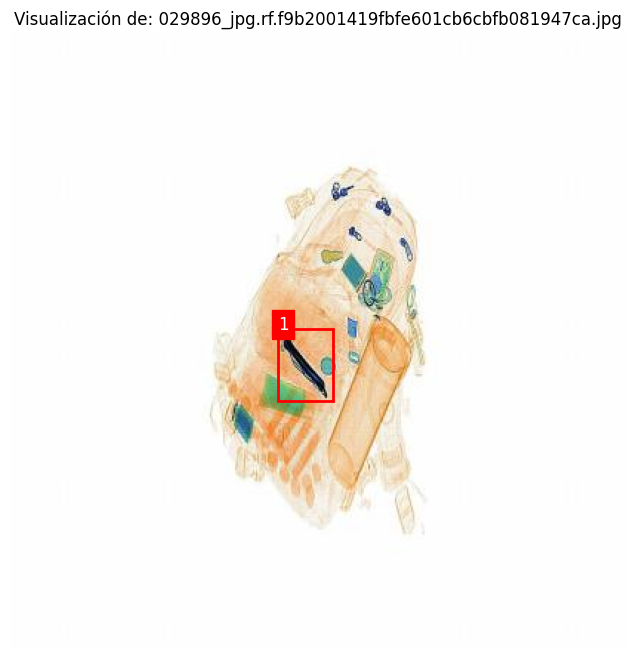

In [5]:
image_files = [f for f in os.listdir(train_images_dir) if f.endswith('.jpg')]
random_image = random.choice(image_files)
visualize_image_with_bboxes(train_images_dir, train_labels_dir, random_image, class_names)

In [6]:
train_images_dir
train_labels_dir
valid_images_dir
valid_labels_dir

'dataset\\valid/labels'

In [7]:
sizes = {}
for img in os.listdir(train_images_dir):
    img_path = os.path.join(train_images_dir, img)
    img = cv2.imread(img_path)
    if img.shape in sizes:
        sizes[img.shape] += 1
    else:
        sizes[img.shape] = 1
for img in os.listdir(valid_images_dir):
    img_path = os.path.join(valid_images_dir, img)
    img = cv2.imread(img_path)
    if img.shape in sizes:
        sizes[img.shape] += 1
    else:
        sizes[img.shape] = 1

In [8]:
print(f"Las imagenes presentes en el dataset presentan las siguientes dimenciones: {sizes}")

Las imagenes presentes en el dataset presentan las siguientes dimenciones: {(416, 416, 3): 7947}


### 2. Análisis de Bounding Boxes

In [9]:
def get_all_bboxes(label_dir):
    """
    Recorre todos los archivos de etiquetas y extrae la información de las bounding boxes.
    """
    bboxes = []
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as f:
                for line in f:
                    parts = list(map(float, line.split()))
                    bboxes.append(parts)
    return np.array(bboxes)

In [10]:
all_train_bboxes = get_all_bboxes(train_labels_dir)
print(f"Total de Bounding Boxes en el set de entrenamiento: {len(all_train_bboxes)}")

classes = all_train_bboxes[:, 0].astype(int)
centers_x = all_train_bboxes[:, 1]
centers_y = all_train_bboxes[:, 2]
widths = all_train_bboxes[:, 3]
heights = all_train_bboxes[:, 4]

Total de Bounding Boxes en el set de entrenamiento: 6181


#### 2.1. Distribución de Tamaños (Área)

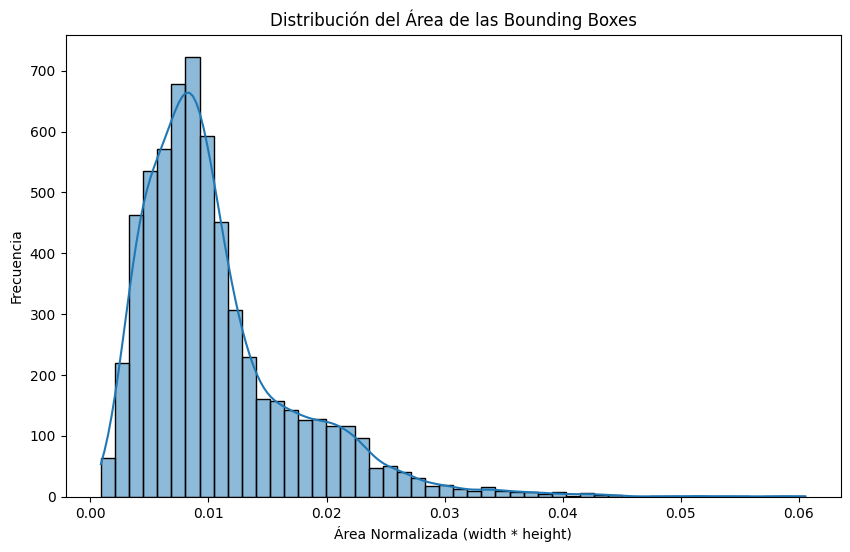

In [11]:
areas = widths * heights
plt.figure(figsize=(10, 6))
sns.histplot(areas, bins=50, kde=True)
plt.title('Distribución del Área de las Bounding Boxes')
plt.xlabel('Área Normalizada (width * height)')
plt.ylabel('Frecuencia')
plt.show()

Lo primero que salta a la vista es que casi todos los objetos que tenemos que encontrar son bastante chicos. Si vemos el gráfico, la mayoría de las cajitas tienen un área bastante pequeña, menos de 0.2. Hay algunos objetos grandes, pero son pocos.

#### 2.2. Distribución de Aspect Ratios

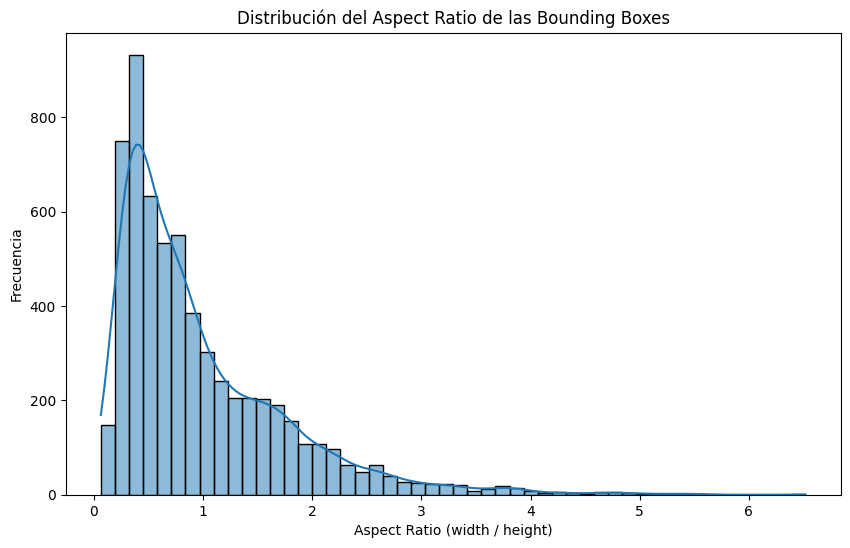

In [12]:
aspect_ratios = widths / heights
plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=50, kde=True)
plt.title('Distribución del Aspect Ratio de las Bounding Boxes')
plt.xlabel('Aspect Ratio (width / height)')
plt.ylabel('Frecuencia')
plt.show()

Acá se ve que los objetos no tienen una única forma. Hay un montón que son más o menos cuadrados (el pico en 1.0), pero también hay bastantes que son más altos que anchos, o más anchos que bajos.

#### 2.3. Mapa de Calor de Ubicaciones

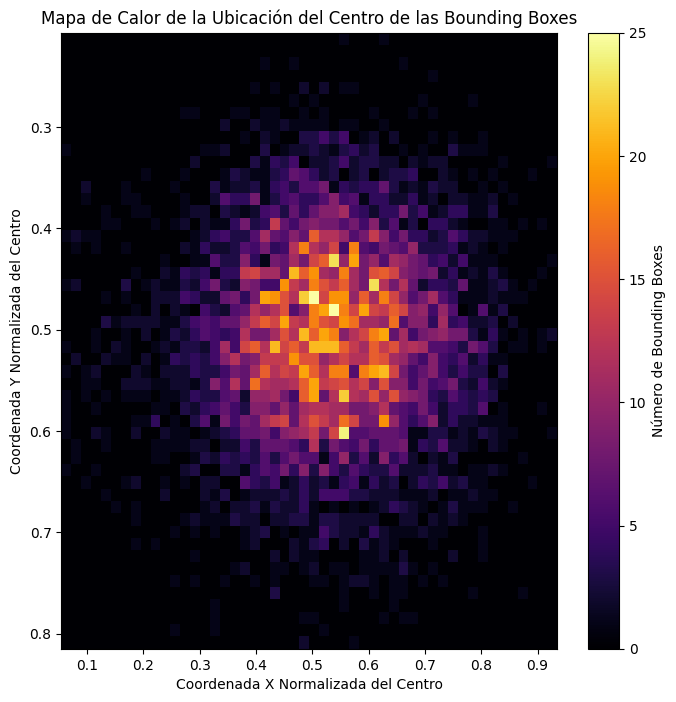

In [13]:
plt.figure(figsize=(8, 8))
plt.hist2d(centers_x, centers_y, bins=50, cmap='inferno')
plt.colorbar(label='Número de Bounding Boxes')
plt.title('Mapa de Calor de la Ubicación del Centro de las Bounding Boxes')
plt.xlabel('Coordenada X Normalizada del Centro')
plt.ylabel('Coordenada Y Normalizada del Centro')
plt.gca().invert_yaxis()

Este gráfico es el más claro de todos. Casi todos los objetos aparecen en el centro de la imagen. A medida que te vas a los bordes, no hay casi nada. Tiene lógica, porque las cosas pasan por el medio del escáner.

### 3. Data Augmentation para Balanceo de Clases

In [14]:
def plot_class_distribution(label_dirs, title, class_names_map):
    """
    Calcula y grafica la distribución de clases a partir de directorios de etiquetas.
    """
    all_classes = []
    if not isinstance(label_dirs, list):
        label_dirs = [label_dirs]

    for label_dir in label_dirs:
        if not os.path.isdir(label_dir):
            print(f"Advertencia: El directorio {label_dir} no existe. Será omitido.")
            continue
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                with open(os.path.join(label_dir, label_file), 'r') as f:
                    for line in f:
                        class_id = int(float(line.split()[0]))
                        all_classes.append(class_id)

    # ocurrencias de cada clase
    class_counts = Counter(all_classes)

    class_indices = sorted(class_counts.keys())
    counts = [class_counts[i] for i in class_indices]
    class_labels = [class_names_map[i] for i in class_indices]

    plt.figure(figsize=(12, 7))
    sns.barplot(x=class_labels, y=counts, hue=class_labels, palette='viridis', legend=False)
    plt.title(title, fontsize=16)
    plt.xlabel('Clase', fontsize=12)
    plt.ylabel('Número de Instancias', fontsize=12)
    plt.xticks(rotation=45)

    for index, value in enumerate(counts):
        plt.text(index, value + 0.5, str(value), ha='center')

    plt.tight_layout()
    plt.show()

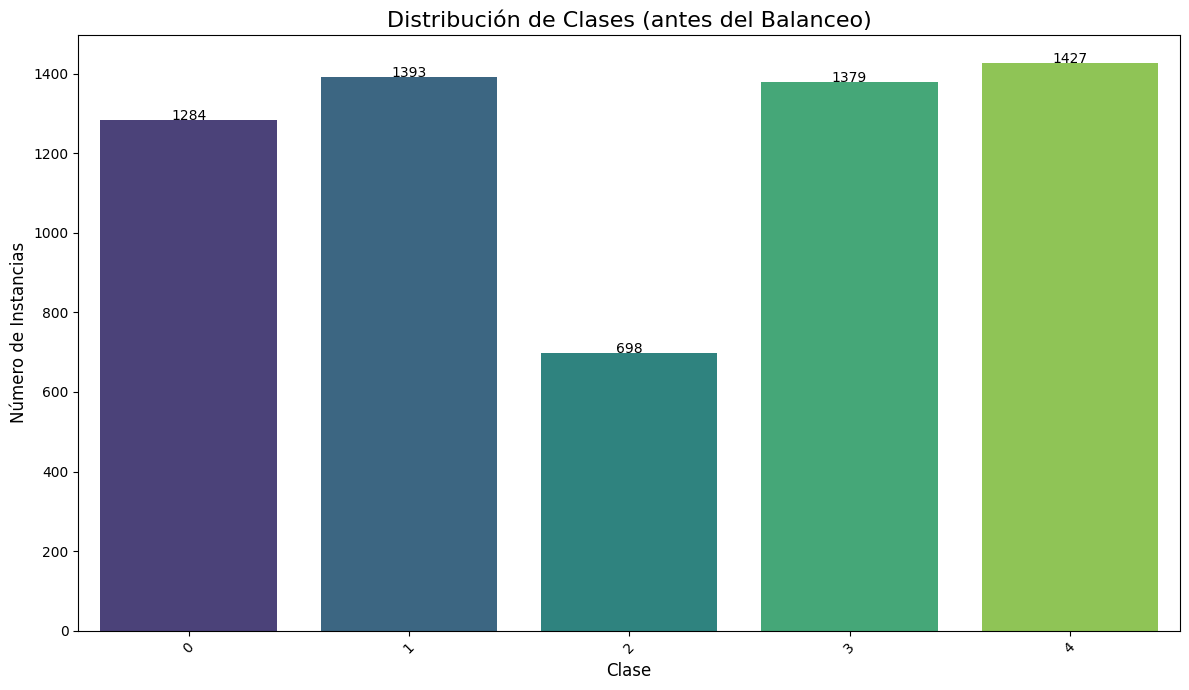

In [15]:
plot_class_distribution([train_labels_dir], 'Distribución de Clases (antes del Balanceo)', class_names)

#### 3.1 Calcular la distribución inicial y definir el objetivo

In [16]:
initial_class_counts = Counter()
for label_file in os.listdir(train_labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(train_labels_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(float(line.split()[0]))
                    initial_class_counts[class_id] += 1

other_class_counts = [count for class_id, count in initial_class_counts.items() if class_id != 2]
target_count = int(np.mean(other_class_counts)) if other_class_counts else 0

initial_count_class_2 = initial_class_counts.get(2, 0)

print(f"Distribución inicial: {sorted(initial_class_counts.items())}")
print(f"Instancias iniciales de la clase '2': {initial_count_class_2}")
print(f"Objetivo de instancias (promedio de las otras clases): {target_count}")

Distribución inicial: [(0, 1284), (1, 1393), (2, 698), (3, 1379), (4, 1427)]
Instancias iniciales de la clase '2': 698
Objetivo de instancias (promedio de las otras clases): 1370


In [17]:
aug_images_dir = os.path.join(os.path.dirname(train_images_dir), 'augmented_images')
aug_labels_dir = os.path.join(os.path.dirname(train_labels_dir), 'augmented_labels')

if os.path.exists(aug_images_dir):
    shutil.rmtree(aug_images_dir)
if os.path.exists(aug_labels_dir):
    shutil.rmtree(aug_labels_dir)
os.makedirs(aug_images_dir, exist_ok=True)
os.makedirs(aug_labels_dir, exist_ok=True)

print(f"\nDirectorios de aumentación limpios en: {aug_images_dir}")


Directorios de aumentación limpios en: dataset\train\augmented_images


In [18]:
class_2_images = []
for label_file in os.listdir(train_labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(train_labels_dir, label_file), 'r') as f:
            for line in f:
                if line.strip() and line.startswith('2 '):
                    class_2_images.append(label_file.replace('.txt', '.jpg'))
                    break

print(f"Se encontraron {len(class_2_images)} imágenes con la clase '2'.")

Se encontraron 698 imágenes con la clase '2'.


In [19]:
if initial_count_class_2 > 0 and initial_count_class_2 < target_count:
    num_augmentations = math.ceil((target_count / initial_count_class_2) - 1)
    num_augmentations = max(1, num_augmentations)
else:
    num_augmentations = 0

print(f"Se generarán {num_augmentations} aumentos por cada imagen de la clase '2'.")

Se generarán 1 aumentos por cada imagen de la clase '2'.


#### 3.2. Definir la pipeline de aumentación

In [20]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=25, p=0.6, border_mode=cv2.BORDER_CONSTANT),
    A.Blur(blur_limit=3, p=0.2),
    A.GaussNoise(p=0.2)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

#### 3.3. Función para generar y guardar imágenes aumentadas

In [21]:
def augment_and_save(image_path, label_path, output_img_dir, output_lbl_dir, transform, num_augmentations):
    """
    Aplica transformaciones a una imagen y su etiqueta, y guarda los resultados.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    bboxes = []
    class_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x, y, w, h = map(float, line.split())
            bboxes.append([x, y, w, h])
            class_labels.append(int(class_id))

    for i in range(num_augmentations):
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']

        base_name = os.path.splitext(os.path.basename(image_path))[0]
        new_img_name = f"{base_name}_aug_{i}.jpg"
        new_lbl_name = f"{base_name}_aug_{i}.txt"

        aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(output_img_dir, new_img_name), aug_image_bgr)

        with open(os.path.join(output_lbl_dir, new_lbl_name), 'w') as f:
            for bbox, class_id in zip(aug_bboxes, augmented['class_labels']):
                x, y, w, h = bbox
                f.write(f"{class_id} {x} {y} {w} {h}\n")

#### 3.4. Aplicar aumentación

In [22]:
if num_augmentations > 0:
    for image_name in class_2_images:
        img_path = os.path.join(train_images_dir, image_name)
        lbl_path = os.path.join(train_labels_dir, image_name.replace('.jpg', '.txt'))

        if os.path.exists(img_path):
            augment_and_save(img_path, lbl_path, aug_images_dir, aug_labels_dir, transform, num_augmentations)

    print("\n¡Proceso de aumentación de datos para la clase '2' completado!")
else:
    print("\nNo fue necesario realizar aumentación de datos para la clase '2'.")


¡Proceso de aumentación de datos para la clase '2' completado!


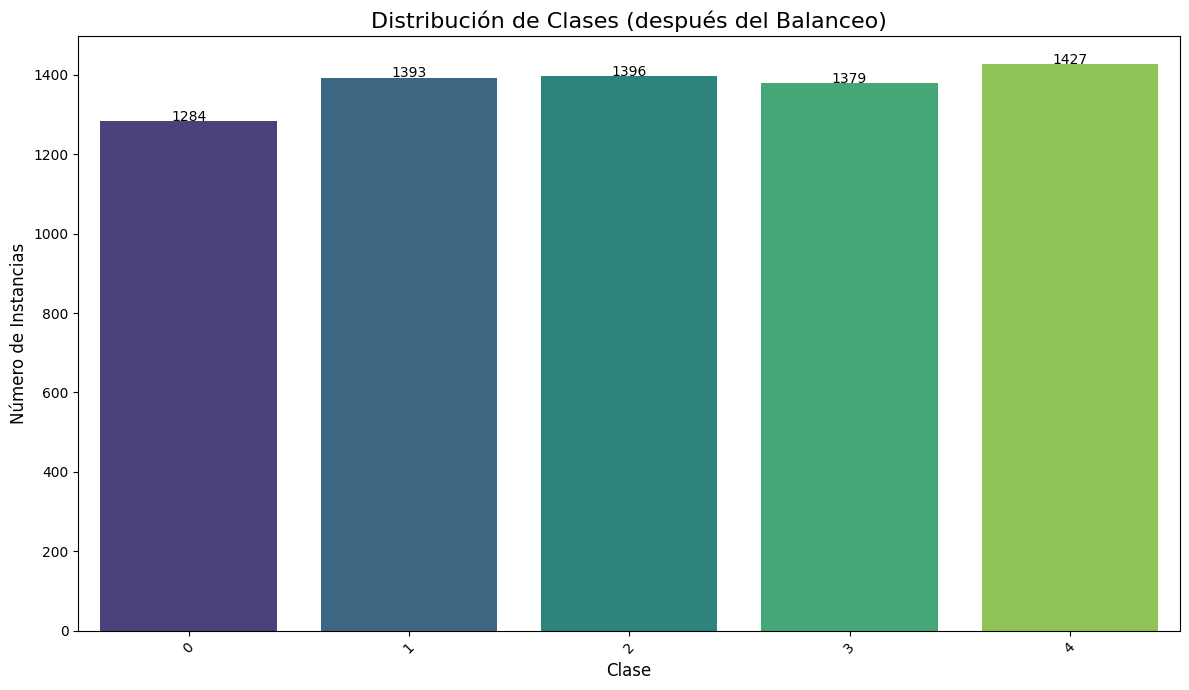

In [23]:
plot_class_distribution([train_labels_dir, aug_labels_dir], 'Distribución de Clases (después del Balanceo)', class_names)

## Segunda entrega: baseline y conclusiones preliminares

### 1.1 Implementacion de Yolo


Se optó por el modelo YOLO debido a que, al ser un detector de una sola etapa (one-stage detector), presenta un rendimiento superior para la detección de objetos pequeños en contraste con otras arquitecturas.

El objetivo inicial del equipo era implementar y realizar una comparativa de desempeño entre tres modelos: YOLO, Faster R-CNN y CornerNet. Debido a limitaciones de tiempo, esta meta no pudo ser completada. No obstante, las diferentes implementaciones y los resultados parciales obtenidos se encuentran disponibles en las distintas ramas del repositorio. De los modelos evaluados, YOLO fue el que demostró un rendimiento superior.

In [24]:
!pip -q install -U ultralytics
from ultralytics import YOLO
import torch, subprocess, sys

In [25]:
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(subprocess.run(["nvidia-smi"], text=True, capture_output=True).stdout[:4000])

CUDA disponible: True
Mon Oct  6 20:06:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.29                 Driver Version: 581.29         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   32C    P8             17W /  170W |     774MiB /  12288MiB |     18%      Default |
|                                         |                        |                  N/A |
+-------------------------

In [26]:
model = YOLO("yolo11s.pt")

results = model.train(
    data=f"{path}/data.yaml",
    epochs=10,
    imgsz=415,
    batch=-1,
    device=0,
    workers=2,
    patience=5,
    project="runs", name="xray_y11_gpu"
)

Ultralytics 8.3.205  Python-3.12.11 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=415, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=xray_y11_gpu, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, p

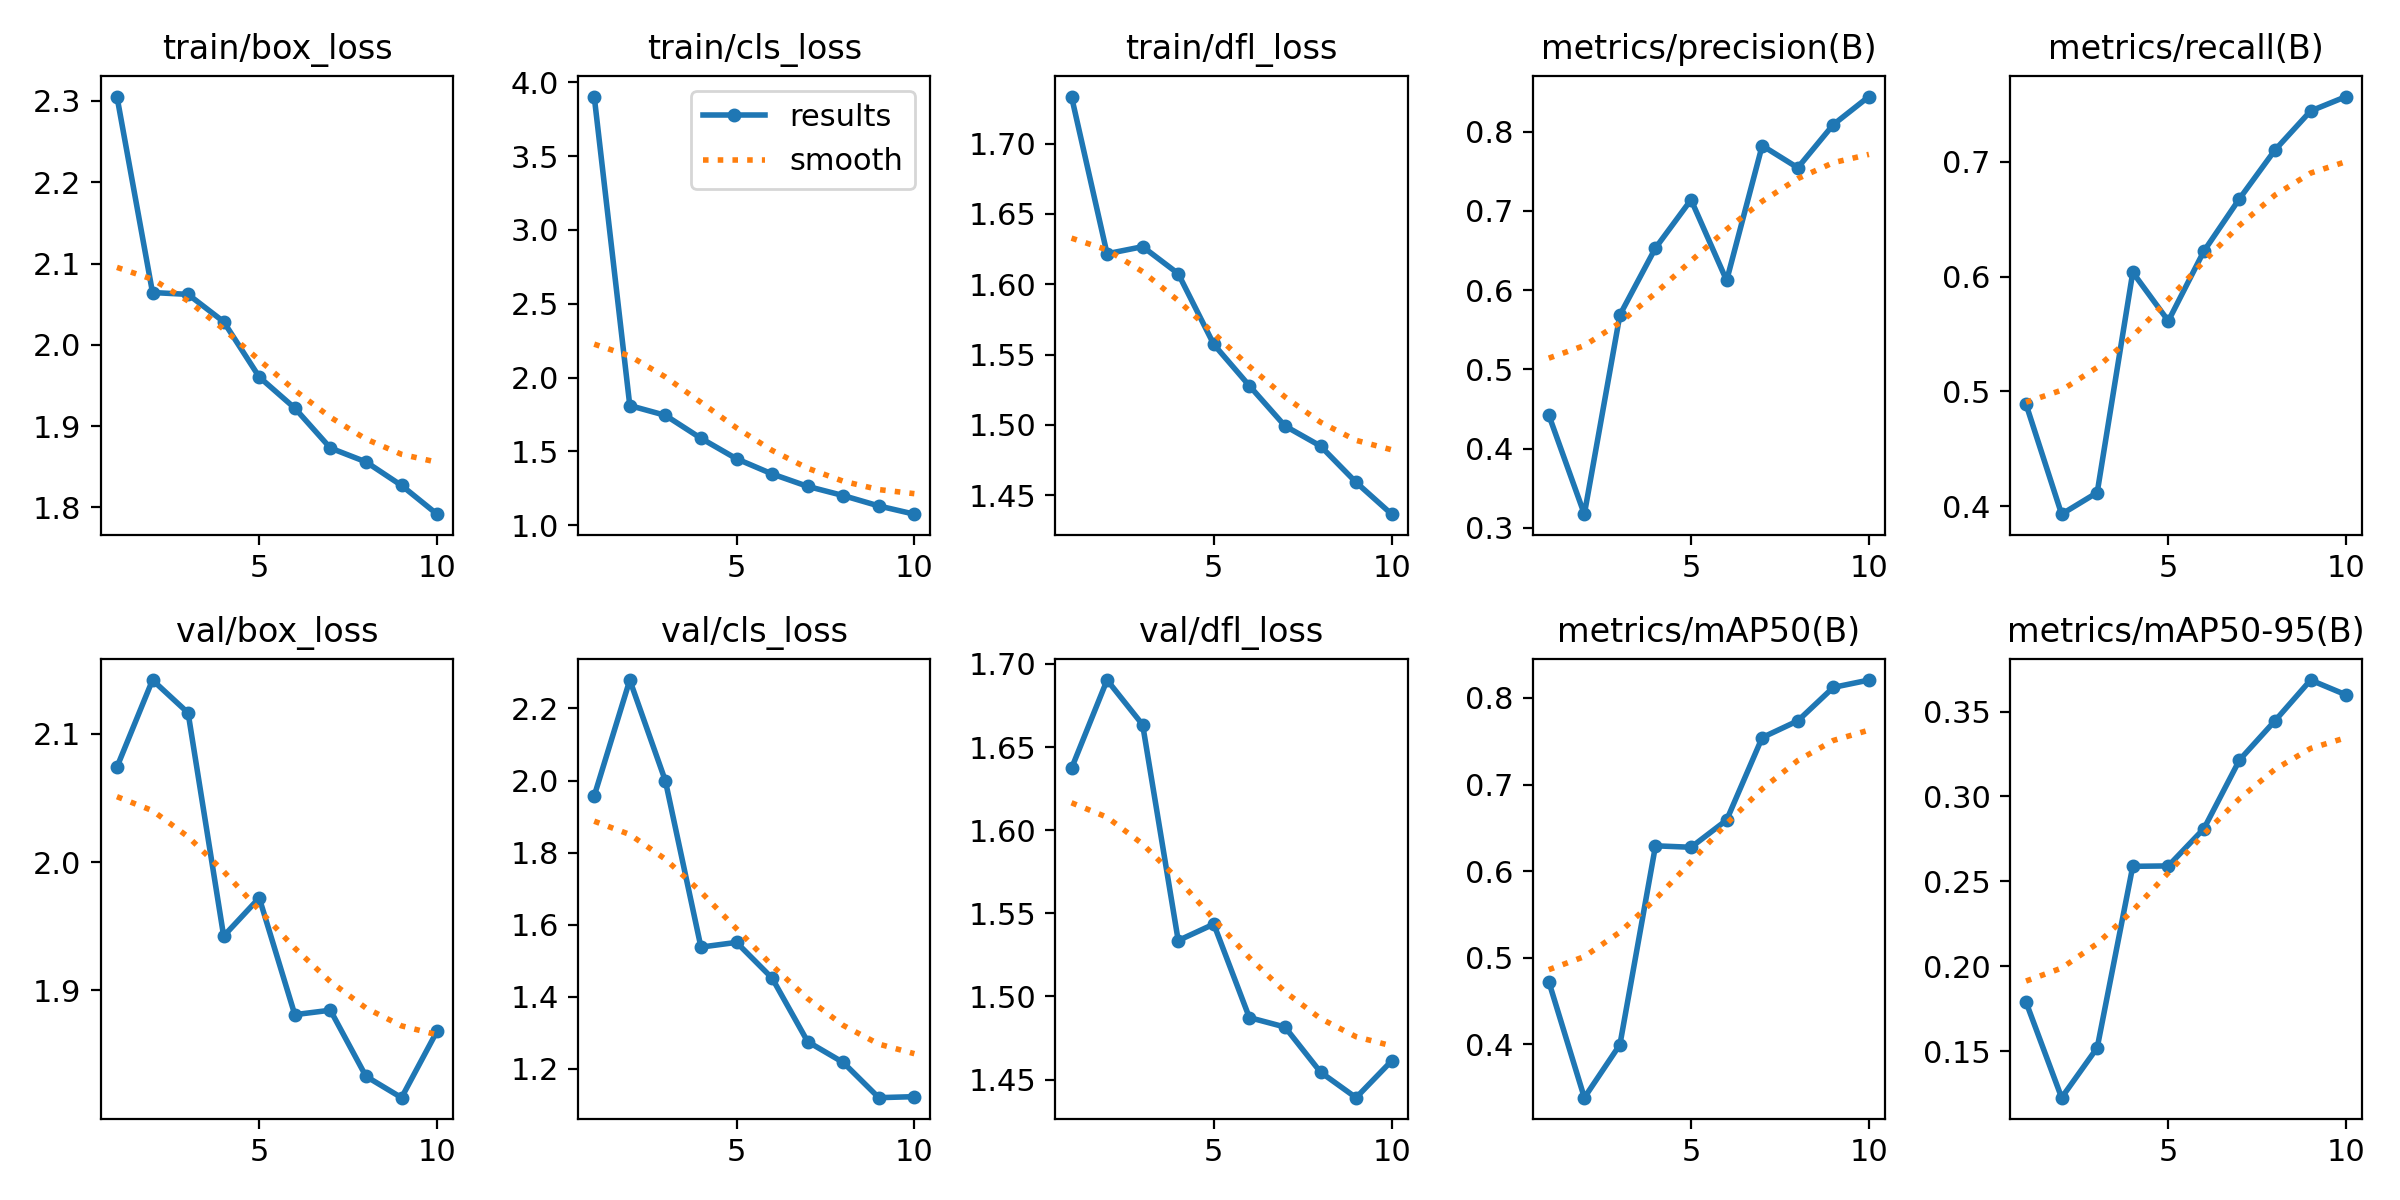

In [29]:
from IPython.display import Image
Image(filename="runs/xray_y11_gpu/results.png")

Se puede observar que con un modlo simplre (sin realizar una busqueda de los mejores hiperparametros) y pocas epocas se logran obtener buenos resultados obteniendo que la precision medai promedio de 50 llega a valorres cercanos 0.8 mientras el caso de 50-95 llega muy proximo a 0.35. Esto muestra que en el caso de querer optimizar este modelo, es posible llegar a resultados inclusive mejores.

In [30]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.205  Python-3.12.11 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 6.95.0 ms, read: 0.50.2 MB/s, size: 18.7 KB)
val: Scanning G:\Mi unidad\Especilizacion IA\Bimestre 4\VPC II\Trabajo-Final-VPC2\dataset\valid\labels.cache... 1766 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1766/1766  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 111/111 10.6it/s 10.5s0.2s
                   all       1766       1766      0.808      0.742       0.81      0.369
                     0        391        391      0.946      0.964      0.976      0.517
                     1        389        389      0.776      0.846      0.875      0.378
                     2        225        225      0.702      0.335      0.527       0.19
                     3        366        366      0.766      0.694 

### 2.2 Validacion de modelo Yolo

In [ ]:
best = "runs/xray_y11_gpu/weights/best.pt"
trained_model = YOLO(best)

# Carpeta completa
trained_model.predict(
    source="dataset/test/images",  # o una carpeta de test
    conf=0.25,    # umbral de confianza
    iou=0.7,      # supresión de no-máximos
    save=True     # guarda imágenes con cajas dibujadas
)

FileNotFoundError: [Errno 2] No such file or directory: '\\content\\runs\\xray_y11_gpu\\weights\\best.pt'

In [ ]:
from IPython.display import Image
Image(filename="runs/xray_y11_gpu/results.png")

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/xray_y11_gpu/results.png'

Usando run: runs\xray_y11_gpu
CSV: runs\xray_y11_gpu\results.csv


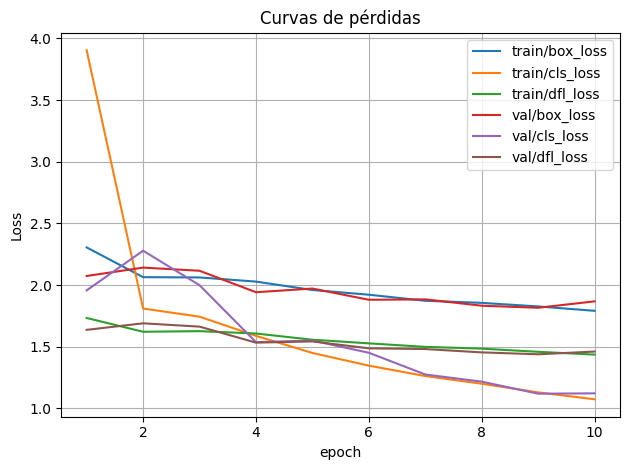

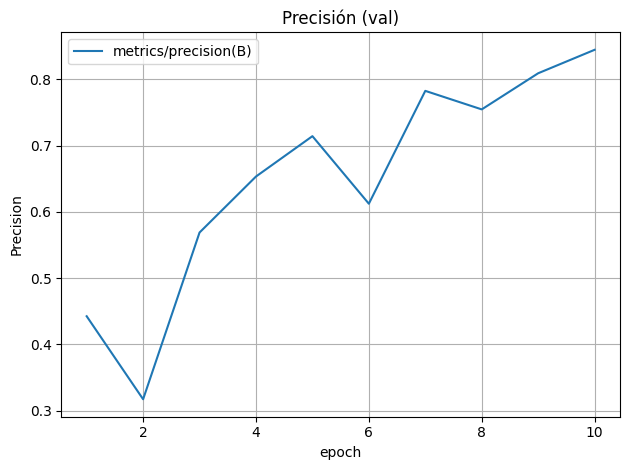

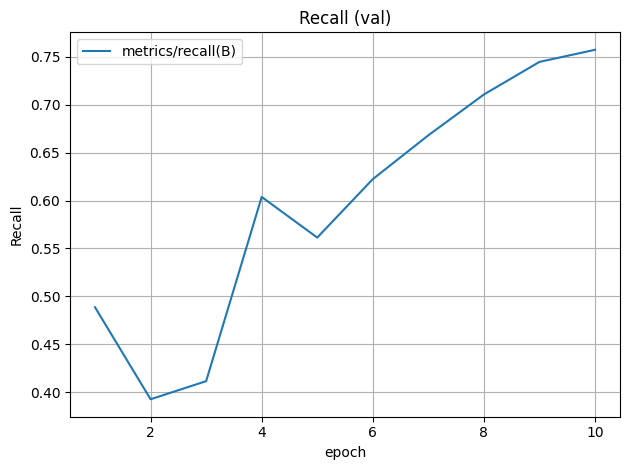

No encontré columnas de mAP en el CSV.
Figuras guardadas en: runs\xray_y11_gpu


In [34]:
# === Graficar curvas desde results.csv de Ultralytics (YOLOv11) ===
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# 1) Ubicar el run
#run_name = None  # por ejemplo "xray_y11_gpu"; usa None para auto-detectar el último run
run_name = "xray_y11_gpu" # Specify the exact run name

base = Path("runs") / "detect"
# Removed the assertion as the base path might vary or not exist before finding the run_dir

if run_name is None:
    # tomar el run más reciente por fecha de modificación
    candidates = [p for p in base.iterdir() if p.is_dir()]
    assert candidates, f"No hay subfolders in {base}"
    run_dir = max(candidates, key=lambda p: p.stat().st_mtime)
else:
    # Construct the full path to the specified run directory
    run_dir = Path("runs") / run_name

assert run_dir.exists(), f"No existe {run_dir}"

# 2) Leer CSV - The results.csv is directly in the run directory
csv_path = run_dir / "results.csv"
assert csv_path.exists(), f"No existe {csv_path}"

print("Usando run:", run_dir)
print("CSV:", csv_path)

# Read the CSV into a DataFrame and assign it to df
df = pd.read_csv(csv_path)

# 3) Función auxiliar para graficar una o varias columnas en una sola figura
def plot_cols(df, xcol, ycols, title, ylabel, outfile):
    plt.figure()  # figura independiente (no subplots)
    for c in ycols:
        if c in df.columns:
            plt.plot(df[xcol], df[c], label=c)
    plt.title(title)
    plt.xlabel(xcol)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(run_dir / outfile, dpi=150)
    plt.show()

# 4) Detectar nombres de columnas típicos (Ultralytics puede variar slightly)
cols = df.columns.str.lower()

def find_first(*keys):
    for k in keys:
        match = [c for c in df.columns if c.lower().startswith(k)] # Use startswith for more flexibility
        if match:
            return match[0]
    return None

# Nombre de la columna de época
epoch_col = find_first("epoch") or df.columns[0]

# Pérdidas (train)
loss_cols = [c for c in df.columns if any(k in c.lower() for k in ["box_loss","cls_loss","dfl_loss"])]

# Métricas (val)
prec_cols = [c for c in df.columns if c.lower().startswith("metrics/precision")]
recall_cols = [c for c in df.columns if c.lower().startswith("metrics/recall")]
map50_cols = [c for c in df.columns if c.lower().startswith("metrics/mmap_0.5")]
map5095_cols = [c for c in df.columns if c.lower().startswith("metrics/mmap_0.5:0.95")]


# 5) Graficar (each plot in its own figure)
if loss_cols:
    plot_cols(df, epoch_col, loss_cols, "Curvas de pérdidas", "Loss", "plot_losses.png")
else:
    print("No encontré columnas de pérdidas (box_loss/cls_loss/dfl_loss) en el CSV.")

if prec_cols:
    plot_cols(df, epoch_col, prec_cols, "Precisión (val)", "Precision", "plot_precision.png")
else:
    print("No encontré columnas de precisión en el CSV.")

if recall_cols:
    plot_cols(df, epoch_col, recall_cols, "Recall (val)", "Recall", "plot_recall.png")
else:
    print("No encontré columnas de recall en el CSV.")

map_cols = map50_cols + map5095_cols
if map_cols:
    plot_cols(df, epoch_col, map_cols, "mAP (val)", "mAP", "plot_map.png")
else:
    print("No encontré columnas de mAP en el CSV.")

print("Figuras guardadas en:", run_dir)

### Busqueda de hiperparametros del modelo

In [35]:
!pip install optuna
import optuna


  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached sqlalchemy-2.0.43-cp312-cp312-win_amd64.whl.metadata (9.8 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached greenlet-3.2.4-cp312-cp312-win_amd64.whl.metadata (4.2 kB)
Using cached sqlalchemy-2.0.43-cp312-cp312-win_amd64.whl (2.1 MB)
Using cached greenlet-3.2.4-cp312-cp312-win_amd64.whl (299 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)
Using cached mako-1.3.10-py3-none-any.whl (78 kB)

   ------ --------------------------------- 1/6 [greenlet]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -

In [36]:
def objective(trial):
  try:
    model = YOLO("yolo11s.pt")
    args = {
        "data": f"{path}/data.yaml",
        "epochs": 10,
        "batch": -1,
        "imgsz": 415,
        "optimizer": 'AdamW',
        "verbose": False,
        "patience": 0,
        'lr0': trial.suggest_float('lr0', 1e-5, 1e-1, log=True),
        'lrf': trial.suggest_float('lrf', 0.01, 1.0),
        'momentum': trial.suggest_float('momentum', 0.6, 0.98),
        'weight_decay': trial.suggest_float('weight_decay', 0.0, 0.001),
        'warmup_epochs': trial.suggest_float('warmup_epochs', 0.0, 5.0),
        'warmup_momentum': trial.suggest_float('warmup_momentum', 0.0, 0.95),
        'box': trial.suggest_float('box', 1.0, 15.0),
        'cls': trial.suggest_float('cls', 0.1, 2.0),
    }

    results = model.train(**args)

    return results.metrics['metrics/mAP50-95(B)']

  except Exception as e:
        print(f"Un 'trial' falló con el error: {e}")
        return 0.0


In [37]:
study = optuna.create_study(direction='maximize')


[I 2025-10-06 20:33:35,089] A new study created in memory with name: no-name-b3996439-7b6e-4511-893e-ef6dbc26076a


In [ ]:
study.optimize(objective, n_trials=75)

Ultralytics 8.3.205  Python-3.12.11 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=14.253438961402919, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.6145931773562434, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=415, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00012755565322607987, lrf=0.5907279363462773, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.871215011533488, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=

[I 2025-10-06 20:43:27,935] Trial 0 finished with value: 0.0 and parameters: {'lr0': 0.00012755565322607987, 'lrf': 0.5907279363462773, 'momentum': 0.871215011533488, 'weight_decay': 0.0004287187964203426, 'warmup_epochs': 3.2965042486226865, 'warmup_momentum': 0.08135249499650839, 'box': 14.253438961402919, 'cls': 0.6145931773562434}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 20:53:25,716] Trial 1 finished with value: 0.0 and parameters: {'lr0': 0.00012369336849367977, 'lrf': 0.7197664223401687, 'momentum': 0.6781731119137056, 'weight_decay': 0.0003771353473727687, 'warmup_epochs': 4.507796493029145, 'warmup_momentum': 0.8283247706797656, 'box': 4.859427670576978, 'cls': 0.4102238686180565}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 21:03:22,058] Trial 2 finished with value: 0.0 and parameters: {'lr0': 0.0034210571256541806, 'lrf': 0.9452054979014196, 'momentum': 0.7550890705305204, 'weight_decay': 0.000432777447015135, 'warmup_epochs': 2.811455755755934, 'warmup_momentum': 0.7594410563090841, 'box': 3.577779917892021, 'cls': 1.5037908406851141}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 21:12:57,413] Trial 3 finished with value: 0.0 and parameters: {'lr0': 9.723248548081234e-05, 'lrf': 0.21866145181121815, 'momentum': 0.7493655666995513, 'weight_decay': 0.00032136318461897106, 'warmup_epochs': 2.540130545652351, 'warmup_momentum': 0.17863229765353747, 'box': 13.667349765685902, 'cls': 1.4142098157986793}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 21:22:57,207] Trial 4 finished with value: 0.0 and parameters: {'lr0': 1.1140304511515247e-05, 'lrf': 0.25463216404079014, 'momentum': 0.6900978084626026, 'weight_decay': 0.0007633103952035536, 'warmup_epochs': 1.3533178326907809, 'warmup_momentum': 0.8971330576448197, 'box': 1.2660442021106226, 'cls': 0.5013011805164658}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 21:32:47,849] Trial 5 finished with value: 0.0 and parameters: {'lr0': 0.0016817013815928216, 'lrf': 0.028820432827961755, 'momentum': 0.9454429404593577, 'weight_decay': 0.0008856103415742405, 'warmup_epochs': 4.497447700668172, 'warmup_momentum': 0.43686936451533775, 'box': 7.402513707425794, 'cls': 1.1455512093659186}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

In [ ]:
print("\n--- ¡Optimización completada! ---")
print("Número de trials finalizados: ", len(study.trials))
print("Mejor trial:")
trial = study.best_trial

print("  Valor (mAP50-95): ", trial.value)
print("  Mejores Hiperparámetros: ")
for key, value in trial.params.items():
        print(f"    {key}: {value}")

In [ ]:
best_hyperparams = trial.params.items()

In [ ]:
model = YOLO('yolov11s.pt')
results = model.train(
    data = f"{path}/data.yaml",
    epochs = 10,
    batch =  -1,
    imgsz =  415,
    optimizer = 'AdamW',
    verbose = False,
    patience = 5,
    name='yolov11_final_tuned_model',
    **best_hyperparams
)

In [ ]:
Image(filename="runs/xray_y11_gpu/results.png")

In [ ]:
# Carpeta completa
trained_model.predict(
    source="dataset/test/images",  # o una carpeta de test
    conf=0.25,    # umbral de confianza
    iou=0.7,      # supresión de no-máximos
    save=True     # guarda imágenes con cajas dibujadas
)